<a href="https://colab.research.google.com/github/Amaljayaranga/ContrastiveLoss/blob/master/SimaseWithDensenet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


Extracting ../data/MNIST/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/MNIST/raw



Extracting ../data/MNIST/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/MNIST/raw



Extracting ../data/MNIST/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/MNIST/raw



Extracting ../data/MNIST/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/MNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:45: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")
/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:55: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:50: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")
/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:60: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/checkpoints/densenet121-a639ec97.pth



training started
epoch: 1 stage: train loss: 0.14250606586535772
epoch: 1 stage: eval loss: 0.14036210420283865


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type SimaseNet. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Model is saving
epoch: 2 stage: train loss: 0.13949612871805828
epoch: 2 stage: eval loss: 0.1384365049765465
Model is saving
epoch: 3 stage: train loss: 0.13950159776210785
epoch: 3 stage: eval loss: 0.13809840650634564
Model is saving
epoch: 4 stage: train loss: 0.13686682595809302
epoch: 4 stage: eval loss: 0.14393987728560226
epoch: 5 stage: train loss: 0.13750664788484573
epoch: 5 stage: eval loss: 0.13811803014671548


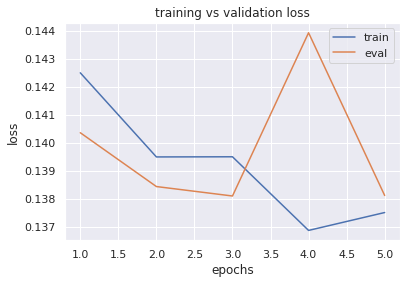

In [1]:
import torch.nn as nn
import torchvision
import torch
import torch.nn.functional as F
from torchvision.datasets import MNIST
from torchvision import transforms
from torch.utils.data import Dataset
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data.sampler import SubsetRandomSampler
from argparse import ArgumentParser
import seaborn as sns;sns.set()
from torch.utils.data import Dataset
from PIL import Image



parser = ArgumentParser(description='Simase Network')
parser.add_argument('--learning_batch_size', type=int, default=128)
parser.add_argument('--fc_in_features', type=int, default=512)
parser.add_argument('--fc_out_features', type=int, default=64)
parser.add_argument('--constractive_loss_margin', type=float, default=1.0)
parser.add_argument('--learning_rate', type=float, default=1e-3)
parser.add_argument('--num_epochs', type=int, default=5)
parser.add_argument('--weight_decay', type=float, default=1e-5)
parser.add_argument('--validation_split', type=float, default=0.2)
parser.add_argument('--sampling', type=str, default='random')
parser.add_argument('--semihard_ratio', type=float, default=1.0)
parser.add_argument('--mode', type=str, default='train')
parser.add_argument('--device', type=str, default='cuda')
args, unknown = parser.parse_known_args()

class SiameseMNIST(Dataset):

    def __init__(self, mnist_dataset, sampling='random', ratio='0.1'):
        self.mnist_dataset = mnist_dataset
        self.train = self.mnist_dataset.train
        self.transform = self.mnist_dataset.transform
        self.sampling = sampling
        self.ratio = ratio

        if self.train:
            self.train_labels = self.mnist_dataset.train_labels
            self.train_data = self.mnist_dataset.train_data
            self.labels_set = set(self.train_labels.numpy())
            self.label_to_indices = {label: np.where(self.train_labels.numpy() == label)[0]
                                     for label in self.labels_set}

        else:
            self.test_labels = self.mnist_dataset.test_labels
            self.test_data = self.mnist_dataset.test_data
            self.labels_set = set(self.test_labels.numpy())
            self.label_to_indices = {label: np.where(self.test_labels.numpy() == label)[0]
                                     for label in self.labels_set}

            random_state = np.random.RandomState(29)


            positive_pairs = [[i,
                               random_state.choice(self.label_to_indices[self.test_labels[i].item()]),
                               0]
                              for i in range(0, len(self.test_data), 2)]
            #print(positive_pairs)

            negative_pairs = [[i,
                               random_state.choice(self.label_to_indices[
                                                       np.random.choice(
                                                           list(self.labels_set - set([self.test_labels[i].item()]))
                                                       )
                                                   ]),
                               1]
                              for i in range(1, len(self.test_data), 2)]
            self.test_pairs = positive_pairs + negative_pairs


    def __len__(self):
        return len(self.mnist_dataset)

    def __getitem__(self, index):

        if self.train:
            target = np.random.randint(0, 2) #0,1
            img1, label1 = self.train_data[index], self.train_labels[index].item()
            if target == 1: #similar ones
                siamese_index = index
                while siamese_index == index:
                    if self.sampling == 'hard':
                        siamese_index = self.hardsampling(index)  #Hard
                    elif self.sampling == 'semi':
                        siamese_index = self.semihardsampling(index, self.ratio)  # Semi
                    else:
                        siamese_index = np.random.choice(self.label_to_indices[label1])  # Random


            else:
                siamese_label = np.random.choice(list(self.labels_set - set([label1])))
                siamese_index = np.random.choice(self.label_to_indices[siamese_label])
            img2 = self.train_data[siamese_index]

        else:
            img1 = self.test_data[self.test_pairs[index][0]]
            img2 = self.test_data[self.test_pairs[index][1]]
            target = self.test_pairs[index][2]

        img1 = Image.fromarray(img1.numpy())
        img2 = Image.fromarray(img2.numpy())

        if self.transform is not None:
            img1 = self.transform(img1)
            img2 = self.transform(img2)

        return img1, img2, target



    def hardsampling(self, index):
        img1, label1 = self.train_data[index], self.train_labels[index].item()
        alloflabel = self.label_to_indices.get(label1)
        distances = {}
        for index in alloflabel:
            distance = torch.sum(F.pairwise_distance(self.train_data[label1].float(), self.train_data[index].float()))
            distances[index] = distance

        sorted_distances = sorted(distances.items(), key=lambda kv: kv[1])
        return sorted_distances[0][0]


    def semihardsampling(self, index, ratio):
        img1, label1 = self.train_data[index], self.train_labels[index].item()
        alloflabel = self.label_to_indices.get(label1)
        distances = {}
        for index in alloflabel:
            distance = torch.sum(F.pairwise_distance(self.train_data[label1].float(), self.train_data[index].float()))
            distances[index] = distance
        sorted_distances = sorted(distances.items(), key=lambda kv: kv[1])
        scale = (sorted_distances[len(sorted_distances)-1][1].item()) - (sorted_distances[0][1].item())
        end_limit = sorted_distances[0][1].item() + scale*ratio
        selected_indexes = []

        for i in range(len(sorted_distances)):
            val = sorted_distances[i]
            if end_limit >= val[1].item():
                selected_indexes.append(val[0])

        selected_indexes_np = np.asarray(selected_indexes)
        return np.random.choice(selected_indexes_np)

DEVICE = args.device
if not torch.cuda.is_available():
    DEVICE = 'cpu'

train_dataset = MNIST('../data/MNIST', train=True, download=True,
                             transform = transforms.Compose([
                                 transforms.ToTensor()
                             ]))

test_dataset = MNIST('../data/MNIST', train=False, download=True,
                            transform = transforms.Compose([
                                transforms.ToTensor()
                            ]))

siamese_train_dataset = SiameseMNIST(train_dataset, sampling=args.sampling)
split = int(np.floor(args.validation_split * len(siamese_train_dataset)))
indices = list(range(len(siamese_train_dataset)))
train_indices, val_indices = indices[split:], indices[:split]
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)

siamese_train_loader = torch.utils.data.DataLoader(siamese_train_dataset, batch_size = args.learning_batch_size,
                                                   sampler=train_sampler)
siamese_val_loader = torch.utils.data.DataLoader(siamese_train_dataset, batch_size = args.learning_batch_size,
                                                  sampler=valid_sampler)
dataloaders =[]
dataloaders.append(siamese_train_loader)
dataloaders.append(siamese_val_loader)

simase_test_dataset = SiameseMNIST(test_dataset)
siamese_test_loader = torch.utils.data.DataLoader(simase_test_dataset, batch_size = 1, shuffle=True)

def splot(img1,img2):
    f, axarr = plt.subplots(1, 2)
    axarr[0].imshow(transforms.ToPILImage()(img1))
    axarr[1].imshow(transforms.ToPILImage()(img2))
    plt.show()

def show_plot(iteration,loss):
    plt.plot(iteration,loss)
    plt.show()

class SimaseNet(nn.Module):

    def __init__(self):
        super(SimaseNet,self).__init__()

        encoder_pretrained = torchvision.models.densenet121(pretrained=True)

        ##to avoid too small size problem
        for x in encoder_pretrained.modules():
            if isinstance(x, nn.AvgPool2d):
                x.ceil_mode = True

        features_pretrained = next(iter(encoder_pretrained.children()))
        # print(features_pretrained)
        conv0 = features_pretrained.conv0
        weights_conv0 = conv0.weight.data

        conv0_new = torch.nn.Conv2d(
            in_channels=1,
            out_channels=conv0.out_channels,
            kernel_size=conv0.kernel_size,
            stride=conv0.stride,
            padding=conv0.padding,
            bias=False
        )
        conv0_new.weight.data[:] = torch.unsqueeze(weights_conv0[:, 1, :, :], dim=1)

        self.encoder = torch.nn.Sequential()
        self.z_num_features = 0
        for name, module in features_pretrained.named_children():
            if name == 'conv0':
                module = conv0_new
            elif name == 'norm5':
                self.z_num_features = module.num_features
            self.encoder.add_module(name, module)
        self.encoder.add_module('avg_pool', torch.nn.AdaptiveAvgPool2d(output_size=1))
        #print(self.encoder)

        #z size = 1024
        self.fc = nn. Sequential(nn.Linear(self.z_num_features, args.fc_in_features),
                                 nn.ReLU(),
                                 nn.Linear(args.fc_in_features,args.fc_in_features),
                                 nn.ReLU(),
                                 nn.Linear(args.fc_in_features,args.fc_out_features)
                                 )


    def forward_once(self, x):
        z = self.encoder(x)
        x = z.view(z.size()[0], -1)
        x = self.fc(x)
        return x

    def forward(self, in1, in2):
        out1 = self.forward_once(in1)
        out2 = self.forward_once(in2)
        return out1, out2

class ContrastiveLoss(nn.Module):

    def __init__(self, margin):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, target):
        eq_distance = F.pairwise_distance(output1, output2)
        loss = 0.5 * (1 - target.float()) * torch.pow(eq_distance, 2) + \
               0.5 * target.float() * torch.pow(torch.clamp(self.margin - eq_distance, min=0.00), 2)
        return loss.mean()


model = SimaseNet()
model = model.to(DEVICE)

if args.mode == 'train':

    criterion = ContrastiveLoss(margin=args.constractive_loss_margin)
    optimizer = torch.optim.Adam(params=model.parameters(), lr=args.learning_rate, weight_decay=args.weight_decay)
    print('training started')
    minimum_loss = float('Inf')

    training_losses = []
    validation_losses = []
    epochs = []

    for epoch in range(1, args.num_epochs + 1):
        epochs.append(epoch)

        for dataloader_idx, dataloader in enumerate(dataloaders):
            stage = ''

            if dataloader_idx == 1:
                model = model.eval()
            else:
                model = model.train()

            epoch_loss = []

            for batch_idx, batch in enumerate(dataloader):
                img1, img2, target = batch
                img1, img2 = img1.to(DEVICE), img2.to(DEVICE)
                out1, out2 = model(img1, img2)
                loss = criterion(out1.to('cpu'), out2.to('cpu'), target)
               

                if dataloader_idx == 0:
                    loss.backward()
                    optimizer.step()
                    optimizer.zero_grad()

                epoch_loss.append(loss.to('cpu').item())

            if dataloader_idx == 0:
                training_losses.append(np.mean(epoch_loss))
                stage = 'train'
            else:
                validation_losses.append(np.mean(epoch_loss))
                stage = 'eval'

            if dataloader_idx == 0:
                print(
                    f'epoch: {epoch} stage: {stage} loss: {np.mean(epoch_loss)}')
            else:
                print(f'epoch: {epoch} stage: {stage} loss: {np.mean(epoch_loss)}')
            
            if dataloader_idx == 1:
                if minimum_loss > np.mean(validation_losses):
                    minimum_loss = np.mean(validation_losses)
                    torch.save(model.to('cpu'), 'simase_best.pt')
                    model = model.to('cuda')
                    print('Model is saving')

    plt.plot(epochs, training_losses, label="train")
    plt.plot(epochs, validation_losses, label="eval")
    plt.xlabel('epochs')
    plt.ylabel('loss')
    plt.title('training vs validation loss')
    plt.legend()
    plt.show()